<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


When TD(5) finds a reward, it propagates information backwards; by contrast, SARSA only updates the value of the current action. Therefore, TD(5) converges faster than SARSA (as the graph shows), and their final episode returns are similar. By the way, which of TD(5) and SARSA achieves a better episode return depends on the value of ε in the ε-greedy algorithm; the larger the ε, the better SARSA tends to perform.

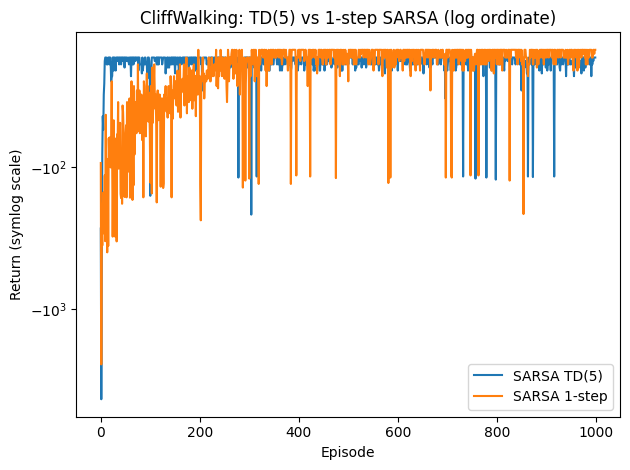


Greedy policy from TD(5):
→ → → → → → → → → → → ↓
→ ↑ ↑ → → → ↑ → → → → ↓
↑ ↑ → ↑ → ↑ ↑ ↑ → ↑ → ↓
S X X X X X X X X X X G

Greedy policy from 1-step SARSA:
→ → ← → → → → → ↓ → → ↓
→ → → → → → → → → → → ↓
↑ → → ↑ → ↑ ↑ ← ↑ ↑ → ↓
S X X X X X X X X X X G


In [13]:


import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
from typing import Tuple, List, Optional

# ----------------------------
# Utilities
# ----------------------------
def epsilon_greedy(Q: np.ndarray, state: int, epsilon: float, n_actions: int) -> int:
    """ε-greedy over Q[s]."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))

def greedy_policy_from_Q(Q: np.ndarray) -> np.ndarray:
    """Deterministic greedy policy π(s) = argmax_a Q(s,a)."""
    return np.argmax(Q, axis=1).astype(int)

def render_policy_grid(policy: np.ndarray, env_name: str = "CliffWalking-v1") -> None:
    """
    Pretty-print the greedy policy for CliffWalking as a 4x12 grid of arrows.
    Marks start (S), goal (G), and cliff (X).
    Action mapping in toy_text: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT.
    """
    env_tmp = gym.make(env_name)
    rows, cols = env_tmp.unwrapped.shape  # expected (4, 12)
    env_tmp.close()

    # Special cells for CliffWalking
    start = (rows - 1, 0)          # bottom-left
    goal  = (rows - 1, cols - 1)   # bottom-right
    cliff_cells = {(rows - 1, c) for c in range(1, cols - 1)}  # bottom row between S and G

    # Arrow mapping
    arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}

    # Build grid strings
    lines = []
    for r in range(rows):
        line_cells = []
        for c in range(cols):
            idx = r * cols + c
            if (r, c) == start:
                cell = "S"
            elif (r, c) == goal:
                cell = "G"
            elif (r, c) in cliff_cells:
                cell = "X"
            else:
                a = int(policy[idx])
                cell = arrows.get(a, "?")
            line_cells.append(cell)
        lines.append(" ".join(line_cells))

    print("\n".join(lines))

# ----------------------------
# SARSA TD(n)
# ----------------------------
def sarsa_td_n(
    env_name: str = "CliffWalking-v1",
    n_step: int = 5,
    n_episodes: int = 5000,
    alpha: float = 0.1,
    gamma: float = 0.99,
    epsilon: float = 0.1,
    seed: Optional[int] = 0,
) -> Tuple[np.ndarray, List[float]]:
    """
    On-policy SARSA with TD(n) (default n=5).
    Returns:
      Q: action-value table
      episode_returns: sum of rewards per episode
    """
    env = gym.make(env_name)
    if seed is not None:
        env.reset(seed=seed)
        np.random.seed(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=float)

    episode_returns: List[float] = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, n_actions)

        # Trajectory buffers (indexed 0..t)
        states, actions, rewards = deque(), deque(), deque()

        T = float("inf")  # time step of terminal transition
        t = 0

        while True:
            if t < T:
                # Step environment using current (state, action)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = bool(terminated or truncated)

                # Log current transition pieces (s_t, a_t, r_t)
                states.append(state)
                actions.append(action)
                rewards.append(reward)

                if done:
                    T = t + 1
                else:
                    # Choose next action on-policy
                    next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                    # Advance current pointers to (t+1) pair for potential bootstrapping
                    state, action = next_state, next_action

            tau = t - n_step + 1
            if tau >= 0:
                # ------- Compute n-step return G(tau) -------
                G = 0.0
                # upper = min(tau+n, T) but avoid int(inf)
                upper = (tau + n_step) if T == float("inf") else min(tau + n_step, int(T))
                # accumulate rewards: r_tau ... r_{upper-1}
                for i in range(tau, upper):
                    G += (gamma ** (i - tau)) * rewards[i]

                # Bootstrap with Q(s_{tau+n}, a_{tau+n}) if tau+n < T
                if (T == float("inf")) or (tau + n_step < int(T)):
                    idx = tau + n_step
                    # If idx already in buffers, use it; if idx == t+1, use current (state, action)
                    if idx <= t:
                        s_tau_n = states[idx]
                        a_tau_n = actions[idx]
                    else:
                        # idx == t+1 (the next pair not yet appended)
                        s_tau_n = state
                        a_tau_n = action
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

                # ------- Update -------
                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1:
                break
            t += 1

        episode_returns.append(sum(rewards))

    env.close()
    return Q, episode_returns

# ----------------------------
# Baseline: 1-step SARSA
# ----------------------------
def sarsa_1step(
    env_name: str = "CliffWalking-v1",
    n_episodes: int = 1000,
    alpha: float = 0.1,
    gamma: float = 0.99,
    epsilon: float = 0.1,
    seed: Optional[int] = 0,
) -> Tuple[np.ndarray, List[float]]:
    """Standard on-policy 1-step SARSA."""
    env = gym.make(env_name)
    if seed is not None:
        env.reset(seed=seed)
        np.random.seed(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=float)

    episode_returns: List[float] = []

    for _ in range(n_episodes):
        s, _ = env.reset()
        a = epsilon_greedy(Q, s, epsilon, n_actions)
        G = 0.0

        while True:
            s_next, r, terminated, truncated, _ = env.step(a)
            done = bool(terminated or truncated)

            if not done:
                a_next = epsilon_greedy(Q, s_next, epsilon, n_actions)
                td_target = r + gamma * Q[s_next, a_next]
            else:
                a_next = None
                td_target = r

            Q[s, a] += alpha * (td_target - Q[s, a])
            G += r

            if done:
                break
            s, a = s_next, a_next

        episode_returns.append(G)

    env.close()
    return Q, episode_returns

# ----------------------------
# Main: train, plot, and print policies
# ----------------------------
if __name__ == "__main__":
    N_EPISODES = 1000
    ALPHA = 0.1
    GAMMA = 0.99
    EPSILON = 0.05
    N = 5
    SEED = 0  # set None for stochastic runs

    # Train TD(5)
    Q5, returns5 = sarsa_td_n(
        n_step=N,
        n_episodes=N_EPISODES,
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,
        seed=SEED,
    )

    # Train 1-step SARSA
    Q1, returns1 = sarsa_1step(
        n_episodes=N_EPISODES,
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,
        seed=SEED,
    )

    # Plot learning curves using a logarithmic y-axis that supports negatives
    plt.figure()
    plt.plot(returns5, label=f"SARSA TD({N})")
    plt.plot(returns1, label="SARSA 1-step")
    plt.xlabel("Episode")
    plt.ylabel("Return (symlog scale)")
    plt.title("CliffWalking: TD(5) vs 1-step SARSA (log ordinate)")
    plt.yscale("symlog")  # handles both negative and positive returns
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----- Print greedy policies as arrow grids -----
    print("\nGreedy policy from TD(5):")
    pi5 = greedy_policy_from_Q(Q5)
    render_policy_grid(pi5, env_name="CliffWalking-v1")

    print("\nGreedy policy from 1-step SARSA:")
    pi1 = greedy_policy_from_Q(Q1)
    render_policy_grid(pi1, env_name="CliffWalking-v1")


## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Dyna-Q tends to move close to the cliff.

The convergence speed with N=20 is significantly faster than with N=5, but is almost the same as with N=50. Conclusion: Increasing N improves sample efficiency, but with diminishing returns.

/tmp/ipython-input-2233204652.py:306: RuntimeWarning: Mean of empty slice
  mas[name] = np.nanmean(ma, axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



=== Sample efficiency thresholds (first episode where MA100 > -30) ===
  Algorithm  First ep where MA(100) > -30.0       Std
Dyna-Q N=20                      161.285714  5.256677
 Dyna-Q N=5                      168.000000  6.391959
Dyna-Q N=50                      159.714286  2.657296
SARSA TD(5)                      161.571429  2.060315
   SARSA(1)                      274.000000 22.709344

=== Final returns over last 100 episodes (mean ± std across seeds) ===
  Algorithm  FinalAvgReturn(last100) Mean  FinalAvgReturn(last100) Std
Dyna-Q N=20                    -17.084286                     1.739293
 Dyna-Q N=5                    -16.621429                     1.384552
Dyna-Q N=50                    -15.760000                     1.200155
SARSA TD(5)                    -17.841429                     0.901165
   SARSA(1)                    -15.472857                     0.398021

--- Policy Plots (greedy) using seed=0 Q-tables ---


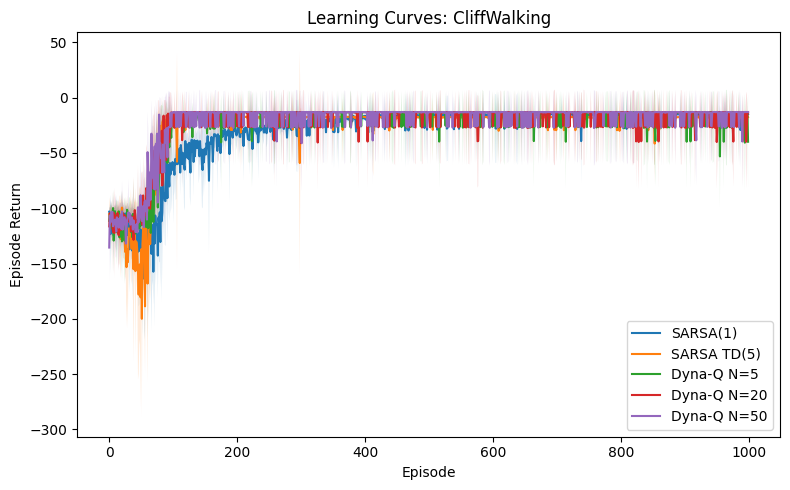

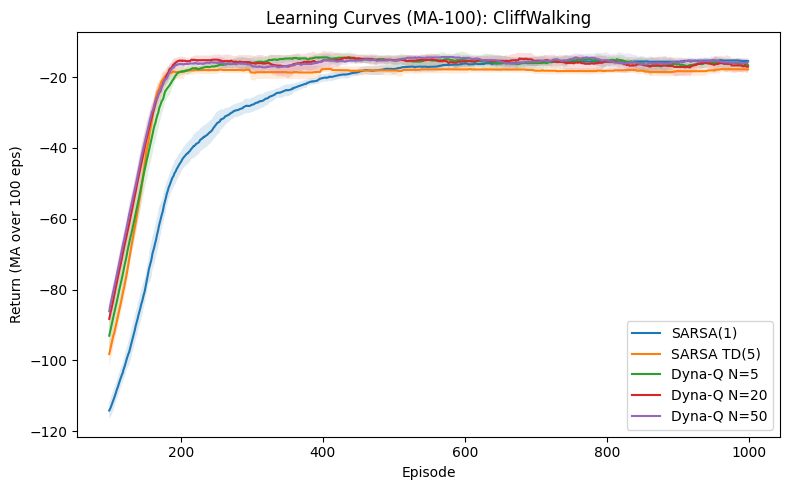

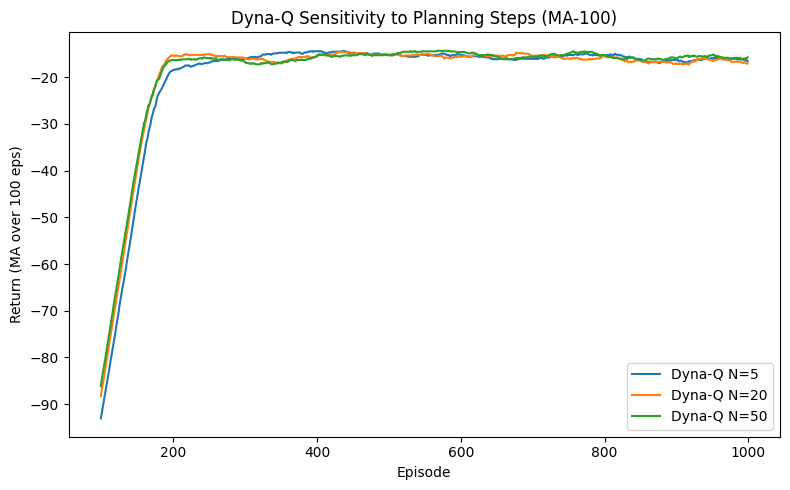

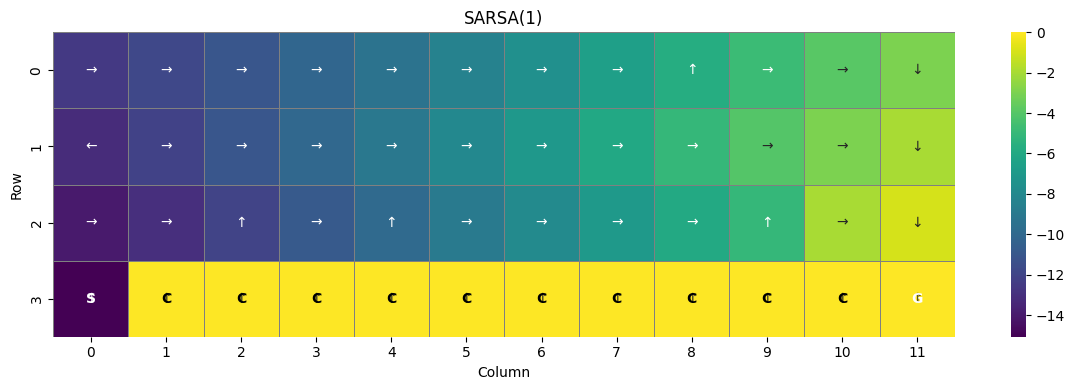

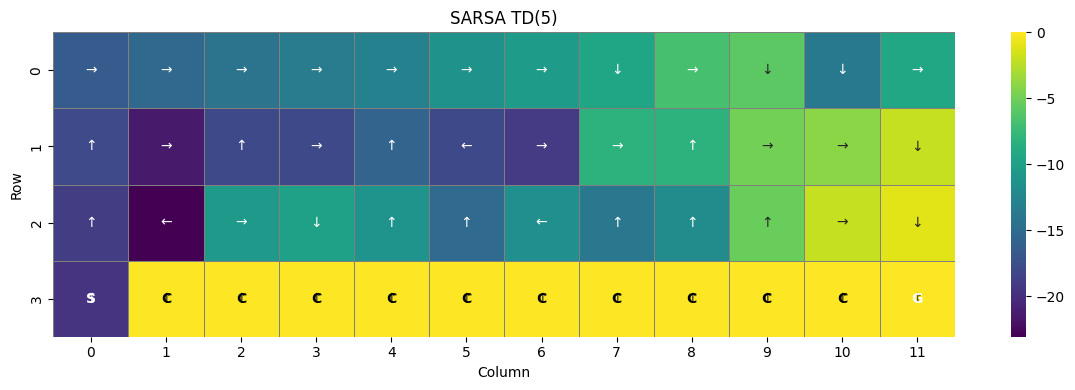

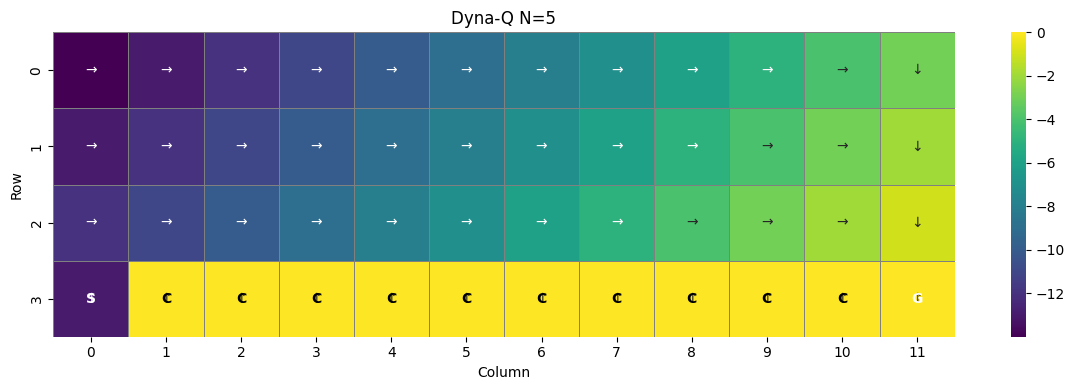

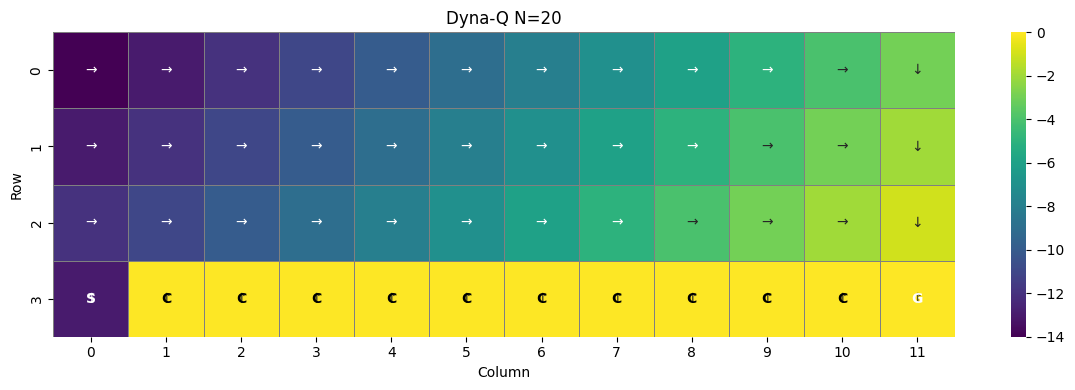

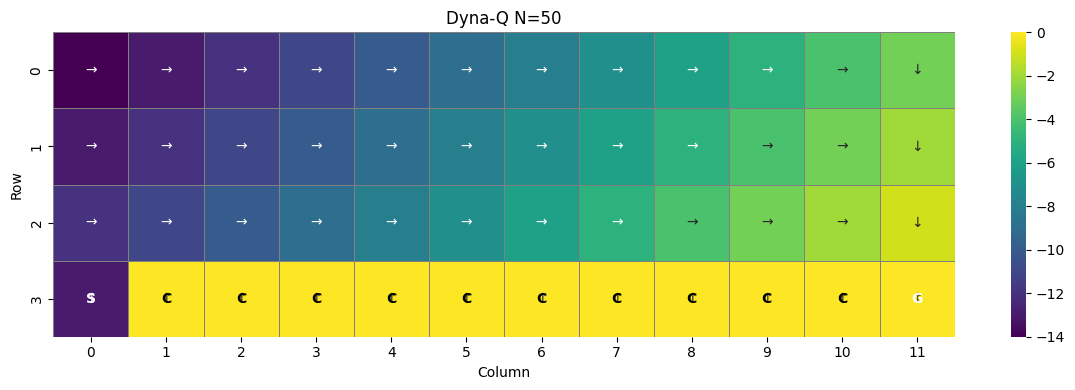


Saved figures:
 - learning_curves.png
 - learning_curves_ma100.png
 - dynaq_sensitivity.png
 - policy_* for each algorithm (PNG)


In [22]:


import math
from dataclasses import dataclass, field
from collections import defaultdict
from typing import Dict, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ============================== Environment ==============================
class CliffWalking:
    """
    Minimal CliffWalking (Gym-like)
      Grid: 4 x 12
      Start: (3,0); Goal: (3,11)
      Cliff: row=3, cols=1..10
    Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
    Rewards: -1 step, -100 cliff (terminal). Reaching goal terminates.
    """
    def __init__(self, seed: Optional[int] = None):
        self.nrow = 4
        self.ncol = 12
        self.start = (3, 0)
        self.goal = (3, 11)
        self.cliff = set((3, c) for c in range(1, 11))
        self.action_space_n = 4
        self.observation_space_n = self.nrow * self.ncol
        self.rng = np.random.RandomState(seed if seed is not None else 0)
        self.reset()

    def to_state(self, pos: Tuple[int, int]) -> int:
        r, c = pos
        return r * self.ncol + c

    def to_pos(self, s: int) -> Tuple[int, int]:
        return (s // self.ncol, s % self.ncol)

    def reset(self) -> int:
        self.pos = tuple(self.start)
        return self.to_state(self.pos)

    def step(self, a: int) -> Tuple[int, float, bool]:
        r, c = self.pos
        if a == 0:   # UP
            r = max(0, r - 1)
        elif a == 1: # RIGHT
            c = min(self.ncol - 1, c + 1)
        elif a == 2: # DOWN
            r = min(self.nrow - 1, r + 1)
        elif a == 3: # LEFT
            c = max(0, c - 1)
        next_pos = (r, c)

        if next_pos in self.cliff:
            reward = -100.0
            done = True
            next_state = self.to_state(next_pos)
            self.pos = next_pos
            return next_state, reward, done

        reward = -1.0
        done = (next_pos == self.goal)
        self.pos = next_pos
        next_state = self.to_state(next_pos)
        return next_state, reward, done


# ============================== Utilities ==============================
def epsilon_greedy(Q: np.ndarray, s: int, eps: float, rng: np.random.RandomState) -> int:
    if rng.rand() < eps:
        return rng.randint(Q.shape[1])
    q = Q[s]
    max_q = np.max(q)
    best_as = np.flatnonzero(np.isclose(q, max_q))
    return rng.choice(best_as)

def lin_decay(start: float, end: float, T: int, t: int) -> float:
    if T <= 1:
        return end
    frac = min(1.0, max(0.0, t / (T - 1)))
    return start + frac * (end - start)

def moving_average(x: np.ndarray, k: int) -> np.ndarray:
    if k <= 1:
        return x.copy()
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    res = (cumsum[k:] - cumsum[:-k]) / k
    out = np.empty_like(x, dtype=float)
    out[:] = np.nan
    out[k-1:] = res
    return out

def first_episode_exceed_threshold(returns: np.ndarray, window: int, thr: float) -> Optional[int]:
    ma = moving_average(returns, window)
    idx = np.where(ma > thr)[0]
    return int(idx[0]) if idx.size > 0 else None


# ============================== Algorithms ==============================
@dataclass
class TrainConfig:
    episodes: int = 500
    gamma: float = 1.0
    alpha: float = 0.5
    eps_start: float = 1.0
    eps_end: float = 0.1
    eps_decay_episodes: int = 500
    max_steps_per_episode: int = 10000  # safety

def q_learning_update(Q: np.ndarray, s: int, a: int, r: float, s2: int, done: bool, cfg: TrainConfig):
    target = r if done else (r + cfg.gamma * np.max(Q[s2]))
    Q[s, a] += cfg.alpha * (target - Q[s, a])

def sarsa1(env_seed: int, cfg: TrainConfig):
    env = CliffWalking(seed=env_seed)
    rng = np.random.RandomState(env_seed)
    Q = np.zeros((env.observation_space_n, env.action_space_n), dtype=float)
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        eps = lin_decay(cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes, ep)
        s = env.reset()
        a = epsilon_greedy(Q, s, eps, rng)
        G = 0.0
        for _ in range(cfg.max_steps_per_episode):
            s2, r, done = env.step(a)
            G += r
            a2 = epsilon_greedy(Q, s2, eps, rng) if not done else 0
            target = r if done else (r + cfg.gamma * Q[s2, a2])
            Q[s, a] += cfg.alpha * (target - Q[s, a])
            s, a = s2, a2
            if done:
                break
        episode_returns.append(G)

    return Q, episode_returns, Q.copy()

def sarsa_td_n(env_seed: int, cfg: TrainConfig, n: int = 5):
    env = CliffWalking(seed=env_seed)
    rng = np.random.RandomState(env_seed + 12345)
    Q = np.zeros((env.observation_space_n, env.action_space_n), dtype=float)
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        eps = lin_decay(cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes, ep)
        s0 = env.reset()
        a0 = epsilon_greedy(Q, s0, eps, rng)
        states = [s0]
        actions = [a0]
        rewards = [0.0]  # r_1 at rewards[1]
        G_ep = 0.0

        T = math.inf
        t = 0
        while True:
            if t < T:
                s_t = states[t]
                a_t = actions[t]
                s_next, r_next, done = env.step(a_t)
                rewards.append(r_next)
                G_ep += r_next
                if done:
                    T = t + 1
                else:
                    states.append(s_next)
                    actions.append(epsilon_greedy(Q, s_next, eps, rng))

            tau = t - n + 1
            if tau >= 0:
                G = 0.0
                upper = min(tau + n, T)
                for i in range(tau + 1, upper + 1):
                    G += (cfg.gamma ** (i - tau - 1)) * rewards[i]
                if tau + n < T:
                    s_up = states[tau + n]
                    a_up = actions[tau + n]
                    G += (cfg.gamma ** n) * Q[s_up, a_up]
                s_tau = states[tau]
                a_tau = actions[tau]
                Q[s_tau, a_tau] += cfg.alpha * (G - Q[s_tau, a_tau])

            t += 1
            if tau == T - 1:
                break

        episode_returns.append(G_ep)

    return Q, episode_returns, Q.copy()

@dataclass
class DynaModel:
    """ Empirical multiset model for Dyna-Q: (s,a) -> list of (s', r, done) """
    outcomes: Dict[Tuple[int, int], List[Tuple[int, float, bool]]] = field(default_factory=lambda: defaultdict(list))
    def update(self, s: int, a: int, s2: int, r: float, done: bool):
        self.outcomes[(s, a)].append((s2, r, done))
    def sample_from_key(self, s: int, a: int, rng: np.random.RandomState):
        outs = self.outcomes.get((s, a))
        if not outs:
            return None
        return outs[rng.randint(len(outs))]

def dyna_q(env_seed: int, cfg: TrainConfig, planning_steps: int = 20):
    env = CliffWalking(seed=env_seed)
    rng = np.random.RandomState(env_seed + 22222)
    Q = np.zeros((env.observation_space_n, env.action_space_n), dtype=float)
    model = DynaModel()
    episode_returns: List[float] = []
    seen_state_actions: List[Tuple[int, int]] = []

    for ep in range(cfg.episodes):
        eps = lin_decay(cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes, ep)
        s = env.reset()
        G = 0.0
        for _ in range(cfg.max_steps_per_episode):
            a = epsilon_greedy(Q, s, eps, rng)
            s2, r, done = env.step(a)
            G += r
            # real Q-learn
            q_learning_update(Q, s, a, r, s2, done, cfg)
            # model update
            model.update(s, a, s2, r, done)
            if (s, a) not in seen_state_actions:
                seen_state_actions.append((s, a))
            # planning
            for _ in range(planning_steps):
                s_p, a_p = seen_state_actions[rng.randint(len(seen_state_actions))]
                sampled = model.sample_from_key(s_p, a_p, rng)
                if sampled is None:
                    continue
                s2_p, r_p, d_p = sampled
                q_learning_update(Q, s_p, a_p, r_p, s2_p, d_p, cfg)
            s = s2
            if done:
                break
        episode_returns.append(G)

    return Q, episode_returns, Q.copy()


# ============================== Training Harness ==============================
def run_all(
    seeds: List[int],
    episodes: int = 600,
    gamma: float = 1.0,
    alpha: float = 0.5,
    eps_start: float = 1.0,
    eps_end: float = 0.1,
    eps_decay_episodes: int = 600,
    planning_steps_list: List[int] = [5, 20, 50],
    nstep_td: int = 5,
    window_for_threshold: int = 100,
    threshold: float = -30.0,
):
    cfg = TrainConfig(
        episodes=episodes,
        gamma=gamma,
        alpha=alpha,
        eps_start=eps_start,
        eps_end=eps_end,
        eps_decay_episodes=eps_decay_episodes,
    )

    algo_names = ["SARSA(1)", f"SARSA TD({nstep_td})"] + [f"Dyna-Q N={N}" for N in planning_steps_list]
    returns = {name: [] for name in algo_names}
    thresholds_hit = {name: [] for name in algo_names}
    final_Qs = {}

    for seed in seeds:
        # SARSA(1)
        Q_s1, ret_s1, _ = sarsa1(seed, cfg)
        returns["SARSA(1)"].append(np.array(ret_s1))
        final_Qs.setdefault("SARSA(1)", []).append(Q_s1)
        th = first_episode_exceed_threshold(np.array(ret_s1), window_for_threshold, threshold)
        thresholds_hit["SARSA(1)"].append(th if th is not None else np.nan)

        # SARSA TD(n)
        Q_sn, ret_sn, _ = sarsa_td_n(seed, cfg, n=nstep_td)
        name_sn = f"SARSA TD({nstep_td})"
        returns[name_sn].append(np.array(ret_sn))
        final_Qs.setdefault(name_sn, []).append(Q_sn)
        th = first_episode_exceed_threshold(np.array(ret_sn), window_for_threshold, threshold)
        thresholds_hit[name_sn].append(th if th is not None else np.nan)

        # Dyna-Q Ns
        for N in planning_steps_list:
            Q_dn, ret_dn, _ = dyna_q(seed, cfg, planning_steps=N)
            name = f"Dyna-Q N={N}"
            returns[name].append(np.array(ret_dn))
            final_Qs.setdefault(name, []).append(Q_dn)
            th = first_episode_exceed_threshold(np.array(ret_dn), window_for_threshold, threshold)
            thresholds_hit[name].append(th if th is not None else np.nan)

    # aggregate
    episodes_arr = np.arange(episodes)
    means = {}
    stds = {}
    mas = {}
    mas_std = {}
    for name in algo_names:
        R = np.stack(returns[name], axis=0)
        means[name] = np.nanmean(R, axis=0)
        stds[name] = np.nanstd(R, axis=0)
        ma = np.vstack([moving_average(r, 100) for r in R])
        mas[name] = np.nanmean(ma, axis=0)
        mas_std[name] = np.nanstd(ma, axis=0)

    # sample efficiency table
    eff_rows = []
    for name in algo_names:
        vals = np.array(thresholds_hit[name], dtype=float)
        eff_rows.append({
            "Algorithm": name,
            f"First ep where MA(100) > {threshold}": float(np.nanmean(vals)),
            "Std": float(np.nanstd(vals)),
        })
    eff_df = pd.DataFrame(eff_rows).sort_values("Algorithm")

    # final returns over last 100
    final_rows = []
    for name in algo_names:
        R = np.stack(returns[name], axis=0)
        tail_means = R[:, -100:].mean(axis=1)
        final_rows.append({
            "Algorithm": name,
            "FinalAvgReturn(last100) Mean": float(np.mean(tail_means)),
            "FinalAvgReturn(last100) Std": float(np.std(tail_means)),
        })
    final_df = pd.DataFrame(final_rows).sort_values("Algorithm")

    # plots
    plt.figure(figsize=(8,5))
    for name in algo_names:
        plt.plot(episodes_arr, means[name], label=name)
        plt.fill_between(episodes_arr, means[name]-stds[name], means[name]+stds[name], alpha=0.15)
    plt.xlabel("Episode")
    plt.ylabel("Episode Return")
    plt.title("Learning Curves: CliffWalking")
    plt.legend()
    plt.tight_layout()
    plt.savefig("learning_curves.png", dpi=150)

    plt.figure(figsize=(8,5))
    for name in algo_names:
        plt.plot(episodes_arr, mas[name], label=name)
        plt.fill_between(episodes_arr, mas[name]-mas_std[name], mas[name]+mas_std[name], alpha=0.15)
    plt.xlabel("Episode")
    plt.ylabel("Return (MA over 100 eps)")
    plt.title("Learning Curves (MA-100): CliffWalking")
    plt.legend()
    plt.tight_layout()
    plt.savefig("learning_curves_ma100.png", dpi=150)

    plt.figure(figsize=(8,5))
    for N in planning_steps_list:
        name = f"Dyna-Q N={N}"
        plt.plot(episodes_arr, mas[name], label=name)
    plt.xlabel("Episode")
    plt.ylabel("Return (MA over 100 eps)")
    plt.title("Dyna-Q Sensitivity to Planning Steps (MA-100)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("dynaq_sensitivity.png", dpi=150)

    return {
        "algo_names": algo_names,
        "returns": returns,
        "means": means,
        "stds": stds,
        "mas": mas,
        "mas_std": mas_std,
        "eff_df": eff_df,
        "final_df": final_df,
        "final_Qs": final_Qs,
        "episodes_arr": episodes_arr,
    }


# ============================== Policy Plot ==============================
def plot_policy(Q: np.ndarray, title="Policy (greedy)", mark_special=True):
    """
    Plot greedy policy arrows over Q-values as a heatmap.
    - Q: [48, 4] for CliffWalking (4x12, 4 actions)
    - title: plot title string
    - mark_special: overlay S (start), G (goal), C (cliff cells)
    """
    n_states, n_actions = Q.shape
    assert n_states == 48 and n_actions == 4, "This plotter assumes 4x12 CliffWalking and 4 actions."

    Q_grid = Q.reshape((4, 12, n_actions))
    best_a = np.argmax(Q_grid, axis=2)
    best_q = np.max(Q_grid, axis=2)

    action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    arrows = np.vectorize(action_arrows.get)(best_a)

    plt.figure(figsize=(12, 4))
    ax = sns.heatmap(
        best_q,
        annot=arrows,
        fmt="",
        cmap="viridis",
        cbar=True,
        linewidths=0.5,
        linecolor="gray"
    )
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    ax.set_title(title)

    # Overlay S/G/C labels
    if mark_special:
        nrow, ncol = 4, 12
        start = (3, 0)
        goal = (3, 11)
        cliff = set((3, c) for c in range(1, 11))
        # seaborn heatmap uses matrix coords: y=row, x=col
        # Add text with contrasting color
        def overlay_text(r, c, text, color="w", weight="bold"):
            ax.text(c + 0.5, r + 0.5, text, ha="center", va="center",
                    color=color, fontsize=10, fontweight=weight)

        overlay_text(start[0], start[1], "S")
        overlay_text(goal[0], goal[1], "G")
        for (r, c) in cliff:
            overlay_text(r, c, "C", color="black", weight="bold")

    plt.tight_layout()
    plt.savefig(f"policy_{title.replace(' ', '_')}.png", dpi=150)
    plt.show()


# ============================== Greedy Path Helper (optional) ==============================
def greedy_path_from_Q(Q: np.ndarray, env_seed: int, max_steps: int = 2000) -> List[int]:
    env = CliffWalking(seed=env_seed)
    s = env.reset()
    path = [s]
    visited = set([s])
    tie_rng = np.random.RandomState(0)
    for _ in range(max_steps):
        q = Q[s]
        a = tie_rng.choice(np.flatnonzero(np.isclose(q, np.max(q))))
        s2, _, done = env.step(a)
        path.append(s2)
        if done or s2 in visited:
            break
        visited.add(s2)
        s = s2
    return path


# ============================== Main ==============================
if __name__ == "__main__":
    SEEDS = [0, 1, 2, 3, 4, 5, 6]

    res = run_all(
        seeds=SEEDS,
        episodes=1000,
        gamma=1.0,
        alpha=0.1,
        eps_start=1.0,
        eps_end=0.01,
        eps_decay_episodes=100,
        planning_steps_list=[5, 20, 50],
        nstep_td=5,
        window_for_threshold=100,
        threshold=-30.0,
    )

    print("\n=== Sample efficiency thresholds (first episode where MA100 > -30) ===")
    print(res["eff_df"].to_string(index=False))

    print("\n=== Final returns over last 100 episodes (mean ± std across seeds) ===")
    print(res["final_df"].to_string(index=False))

    # Plot policies for trained Q (seed 0) for each algorithm
    algo_names = res["algo_names"]
    print("\n--- Policy Plots (greedy) using seed=0 Q-tables ---")
    for name in algo_names:
        Q_seed0 = res["final_Qs"][name][0]
        plot_policy(Q_seed0, title=name)

    print("\nSaved figures:")
    print(" - learning_curves.png")
    print(" - learning_curves_ma100.png")
    print(" - dynaq_sensitivity.png")
    print(" - policy_* for each algorithm (PNG)")


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
